In [1]:
import numpy as np
from enum import Enum
from IPython.core.display import HTML,display
import pandas as pd
import copy
import random
from collections import deque
import matplotlib.pyplot as plt

# TP final Heurística GRASP para MSA

## Needleman-Wunsch del TP anterior

In [2]:
class op(Enum):
    MA_MM = 0
    GAP_A = 1
    GAP_B = 2
    EMPTY = 3


In [3]:
score_mtx = np.full((4,4),-1) + np.identity(4) *2
score_mtx

array([[ 1., -1., -1., -1.],
       [-1.,  1., -1., -1.],
       [-1., -1.,  1., -1.],
       [-1., -1., -1.,  1.]])

In [4]:
nucleotides= "ACGT-"

### TRACEBACK

In [5]:

def traceback(solution_table, seqA, seqB):
    seqA_align = ""
    seqB_align = ""
    i = len(seqA)
    j = len(seqB)
    while i > 0 or j > 0:
        if solution_table[i, j] == op.GAP_A:
            seqA_align = "-" + seqA_align
            seqB_align = seqB[j-1] + seqB_align
            j -= 1
        elif solution_table[i, j] == op.GAP_B:
            seqA_align = seqA[i-1] + seqA_align
            seqB_align = "-" + seqB_align
            i -= 1
        else: # es decir, match / mismatch
            i -= 1
            j -= 1
            seqA_align = seqA[i] + seqA_align
            seqB_align = seqB[j] + seqB_align
    return seqA_align, seqB_align



### Needleman-Wunsch

In [6]:
def nw(seqA_str, seqB_str, score_mtx, gap_score = 0):
    dim_A = len(seqA_str)
    dim_B = len(seqB_str)
    
    table = get_init_value_table(dim_A,dim_B,gap_score)
    memorization_table = get_init_memo_table(dim_A,dim_B)
    for i in range(1,dim_A+1):
        for j in range(1,dim_B+1):
            nucleotid_A = nucleotides.index(seqA_str[i-1])
            nucleotid_B =nucleotides.index(seqB_str[j-1])
            
            match_or_mismatch_value = table[i-1][j-1] + score_mtx[nucleotid_A][nucleotid_B]

            gap_A_value = table[i][j-1] + gap_score
            gap_B_value = table[i-1][j] + gap_score
            values = [match_or_mismatch_value, gap_A_value, gap_B_value]
            index_min = max(range(len(values)), key=values.__getitem__)
            table[i][j] = values[index_min]
                        
            memorization_table[i][j] = op(index_min)                     
            
    aln_a, aln_b = traceback(memorization_table,seqA_str, seqB_str)
    return aln_a, aln_b, table[dim_A, dim_B]


 
    

def get_init_value_table(x,y,gap_score):
    table = np.zeros((x+1, y+1))
    for i in range(0,y+1):
        table[0,i] = gap_score * i
    for j in range(0,x+1): 
        table[j,0] = gap_score * j
    return table



-------

# Profile

La clase Profile contendra:
- El conteo de los nucleotidos de las secuencias alineadas
- Una lista con todas las alineaciones al momento
- La cantidad de alineaciones alojadas en profile
- El tamaño de las secuencias alojadas
- Un parser sobre nucleotidos.

In [7]:
class Profile:

    def __init__(self):
        self.counter = [[],[],[],[],[]]
        self.sequences = []
        self.size_sequences= 0
        self.seq_numbers = 0
        self.score_history = 0
        self.parser= {"A":0,"C":1,"G":2,"T":3,"-":4}

    def add_sequence(self, sequence, score):
        if self.size_sequences < len(sequence):
            for a in range(0,5):
                self.counter[a] = self.counter[a] + ([0] * (len(sequence)-self.size_sequences))
            self.size_sequences= len(sequence)
        self.seq_numbers += 1
        self.score_history = score
        self.sequences.append(sequence)
        for idx, val in enumerate(sequence):
            self.counter[self.parser[val]][idx] += 1
    
    def add_gap_counter(self, position):
        for idx, seq in enumerate(self.sequences):
            self.sequences[idx] = self.insert_gap(seq,position)
        for a in range(0,4):
            self.counter[a].insert(position,0)
        self.counter[4].insert(position, self.seq_numbers)
        self.size_sequences += 1
    
    def insert_gap(self, a_string, position):
        return a_string[:position] + "-" + a_string[position:]
    
    def get_count_position(self,position):
        count = []
        for a in range(0,5):
            count.append( self.counter[a][position] / self.seq_numbers)
        return tuple(count)
        #return self.counter[0,position], self.counter[1,position], self.counter[2,position], self.counter[3,position]
        
    def print_seq(self):
        print(np.array(self.sequences).reshape(self.seq_numbers,1))
        display(headers_table(np.array(self.counter),"ACGT-",range(1,self.size_sequences+1)))
            
def headers_table(table, header,col_header):
    row_labels = [label for label in header]
    column_labels = [label for label in col_header]
    df = pd.DataFrame(table,index=row_labels,columns=column_labels)
    table_html = df.to_html()
    return HTML(table_html)

### Needleman-Wunsch MSA

In [8]:
def nw_msa(seq_str, profile, score_mtx, gap_score = 0):
    dim_seq = len(seq_str)
    dim_profile = profile.size_sequences
    
    table = get_init_value_table(dim_seq,dim_profile,gap_score)
    memorization_table = get_init_memo_table(dim_seq,dim_profile)
    for i in range(1,dim_seq+1):
        for j in range(1,dim_profile+1):
            nucleotide = nucleotide_index(seq_str[i-1])
            
            a, c, g, t, gap = profile.get_count_position(j-1)
            score_position = a * score_mtx[nucleotide][nucleotide_index("A")] + c * score_mtx[nucleotide][nucleotide_index("C")]+ g * score_mtx[nucleotide][nucleotide_index("G")]+ t * score_mtx[nucleotide][nucleotide_index("T")]
            gap_porcent_value = 1 - (a+c+g+t)
            match_or_mismatch_value = table[i-1][j-1] + score_position
            
            gap_profile_value = table[i][j-1] + gap_score
                                             
            gap_seq_value = table[i-1][j] + (gap_score * gap_porcent_value)
            values = [match_or_mismatch_value, gap_profile_value, gap_seq_value]
            index_min = max(range(len(values)), key=values.__getitem__)
            table[i][j] = values[index_min]
                        
            memorization_table[i][j] = op(index_min)
    aln_seq, gaps_profile = traceback_msa(memorization_table,seq_str, profile)
    return aln_seq, gaps_profile, table[dim_seq, dim_profile]

def get_init_memo_table(dim_A,dim_B):
    table = np.full((dim_A+1,dim_B+1),op.EMPTY)
    for i in range(1,dim_B+1):
        table[0][i] = op.GAP_A
    for j in range(1,dim_A+1):
        table[j][0] = op.GAP_B
    return table

def nucleotide_index(nucleotide):
    return nucleotides.index(nucleotide)

### traceback msa

In [9]:

def traceback_msa(solution_table, seq, profile):
    seq_align = ""
    gaps_profile = []
    i = len(seq)
    j = profile.size_sequences
    while i > 0 or j > 0:
        if solution_table[i, j] == op.GAP_A:
 
            seq_align = "-" + seq_align
            j -= 1
        elif solution_table[i, j] == op.GAP_B:
            seq_align = seq[i-1] + seq_align
            gaps_profile.append(i-1)
            i -= 1
        else: # es decir, match / mismatch
            i -= 1
            j -= 1
            seq_align = seq[i] + seq_align
    return seq_align, gaps_profile

### Carga de datos
La función ***get_fasta_sequences*** nos va a permitir a partir del nombre de un archivo, de tipo fasta, buscarlo en la raiz del proyecto y parsearlo para obtener una lista de secuencias

In [10]:
def get_fasta_sequences(file):
    seqs = []
    with open(file) as fp:
        for name, seq in read_fasta(fp):
            seqs.append(seq)
    return seqs

def read_fasta(fp):
        name, seq = None, []
        for line in fp:
            line = line.rstrip()
            if line.startswith(">"):
                if name: yield (name, ''.join(seq))
                name, seq = line, []
            else:
                seq.append(line)
        if name: yield (name, ''.join(seq))

## Orden de alineamiento de secuencias

Nos dedicaremos a dar un orden adecuado a nuestras secuencias, lo que nos permitira aumentar el scoring.
Para lograr ello tenemos que iniciar alineando todas las secuencias entre si. Recorriendo y procesando una matriz.

![](extras/matrix_1.png)

En nuestro caso completamos una lista carga de forma ordenada las secuencias, y descarta las que quedan fuera de esa lista, indicandonos el score obtenido por alinear 2 secuencias y tambien un par indicando el indice de las mismas

In [11]:
def nw_secuences(sequences, score_mtx, gap_penalty, len_result = 4):
    cant_seq = len(sequences)
    matrix_align = np.full((cant_seq,cant_seq),None)
    max_values = [(-np.Inf,(-1,-1)) for x in range(0, len_result)]
    for i in range(0,cant_seq):
        for j in range(i+1,cant_seq):
            align_1,align_2,score = nw(sequences[i],sequences[j],score_mtx, gap_penalty)
            matrix_align[i][j] = (align_1,align_2)
            x = 0
            while x < len_result and max_values[x][0] > score :
                x+=1
            if x < len_result :
                max_values.insert(x,(score,(i,j)))
                max_values.pop()
                
    return max_values, matrix_align

Algo similar sucede cuando queremos encontrar un orden optimo en el resto de las secuencias, a diferencia, el resto de las secuencias van a alinearse con un unico profile

![](extras/matrix_2.png)

Esta lista que obtenemos obtiene los scoring de recorrer un profile y alguna de las secuencias restantes. tambien indica que secuencia es la que corresponde al scoring de dicho alineamiento

In [12]:
def nw_msa_secuences(sequences, profile, sequences_availables, score_mtx, gap_penalty, len_result = 3):
    cant_seq = len(sequences)
    max_values = [(-np.Inf,-1) for x in range(0, len_result)]
    for i in sequences_availables:
        _, _, score = nw_msa(sequences[i], profile, score_mtx, gap_penalty)
        x = 0
        while x < len_result and max_values[x][0] > score:
            x+=1
        if x < len_result:
            max_values.insert(x,(score,i))
            max_values.pop()
                
    return max_values

## Soluciones ordenadas aleatorias

Es momento de armar Soluciones a partir de un ordenamiento de secuencias, diferentes ordenes nos devuelve soluciones iniciales diferentes, por eso es necesario agregar un grado de aleatoriedad a nuestro algoritmo con un criterio para que nos lleve a soluciones aceptables.

In [13]:
def align(sequences, score_mtx, gap_penalty):
    
    order_sequences = []
    sequence_numbers = list(range(0,len(sequences)))
    p_align = Profile()
    
    sequences_observer_size = len(sequences)//2+1
    
    list_score_nw, mtx_align = nw_secuences(sequences, score_mtx, gap_penalty, sequences_observer_size)
    sequences_index_random = random.randrange(0, sequences_observer_size)
    score , (position_a, position_b) = list_score_nw[sequences_index_random]
    
    align1, align2 = mtx_align[position_a][position_b]
    p_align.add_sequence(align1,score) 
    p_align.add_sequence(align2,score)
    
    sequence_numbers.remove(position_b)
    sequence_numbers.remove(position_a)
    order_sequences.append(position_b)
    order_sequences.append(position_a)
    
    align_with_profile(p_align ,sequences,order_sequences, sequence_numbers, score_mtx, gap_penalty)
    
    return p_align, order_sequences

In [14]:
def align_with_profile(profile_align ,sequences,order_sequences, pending_sequences, score_mtx, gap_penalty):
    
    pending_observe_sequences_size = len(pending_sequences)//2+1
    
    nw_msa_list = nw_msa_secuences(sequences, profile_align, pending_sequences, score_mtx, gap_penalty, pending_observe_sequences_size)
    
    sequences_index_random = random.randrange(0, pending_observe_sequences_size)
    _ , ramdom_sequence_number  = nw_msa_list[sequences_index_random]
    
    order_sequences.append(ramdom_sequence_number)
    pending_sequences.remove(ramdom_sequence_number)
    
    seq_align, gaps_profile, score_align = nw_msa(sequences[ramdom_sequence_number], profile_align, score_mtx, gap_penalty)
    for position_gap in gaps_profile:
        profile_align.add_gap_counter(position_gap)
    profile_align.add_sequence(seq_align,score_align)
    
    if pending_sequences:
         align_with_profile(profile_align ,sequences,order_sequences, pending_sequences, score_mtx, gap_penalty)
    

la función ***align*** crea alineaciones en ordenes bajo un criterio pero con un grado de aleatoriedad, nos devuelve un profile con todos los alineamientos y un orden con el cual fue cargado dicho profile

Al tener nuestras secuencias ordenadas de una forma especifica y tener ese orden.. vamos a buscar en sus resultados vecinos si obtenemos un mejor score.

### La maquina de soluciones

la funcion ***nw_GRASP*** genera todas las soluciones que le pidamos. Esas soluciones incluyen los score, los ordenes y los profiles. 

In [15]:
def nw_GRASP(solutions, sequences, score_mtx, gap_penalty):
    scores = []
    orders = []
    profiles = []
    for i in range(0,solutions):
        profile, order_sequences = align(sequences, score_mtx, gap_penalty)
        scores.append(profile.score_history)
        orders.append(order_sequences)
        profiles.append(profile)
        print('Solution', i, 'score:', profile.score_history, 'order_added:',order_sequences)
    return scores,orders, profiles

## Multiple Sequence Alignment

'msa' es nuestra función raiz, a partir de un documento fasta vamos a obtener un alineamiento de varias secuencias con un scoring aceptable a un tiempo razonable

In [16]:
def msa(fasta_file, score_mtx, gap_penalty, n_solutions = 3, local_iterations=250):
    #Parser fasta file
    sequences = get_fasta_sequences(fasta_file)

    orders, scores, profiles = nw_GRASP(n_solutions, sequences, score_mtx, gap_penalty)
    res = []
    for profile in profiles:
        res.append(maximium_local(profile.sequences, profile.seq_numbers, profile.score_history, score_mtx, gap_penalty, local_iterations))
    best_score = -np.Inf
    bad_score = np.Inf
    best_align = []
    for aligns,h_s in res:
        if best_score < h_s[-1]:
            best_score = h_s[-1]
            best_align = aligns
        if bad_score > h_s[0]:
            bad_score = h_s[0]
    #Create Output with alignment
    data = ""
    for idx, align in enumerate(best_align):
        data += "seq"+str(idx) +"\n"+ align +"\n" 
    f = open("output.txt", "w")
    f.write(data)
    f.close()
    return res, best_score, bad_score, best_align

### Maximo Local

La función maximium_local nos permite una correccion de nuestra solución generando pequeños cambios aleatorios sobre algún alineamiento realizado. Genera cambios que permiten obtener un mejor scoring.

In [17]:
def maximium_local(sequences,cant_sequences, score, score_mtx, gap_penalty,local_iterations):
    history = [score]
    i=0
    while i < local_iterations :
        i+=1
        score = correction_with_neightboard(sequences, score, cant_sequences, score_mtx, gap_penalty)
        history.append(score)
    return sequences, history

#### Descubriendo el vecindario

Para lograr la busqueda local debemos encontrar vecinos en un alineamiento, para eso tenemos la función ***neighboard_of*** que apartir de un alineamiento busca modificaciones en la secuencia que no generen mutaciones. Obteniendo como resultado distintas soluciones para un unico alineamiento.

In [18]:
def neighboard_of(alig):
    neighboard = []
    n_neighboards = 0
    for i in range(0,len(alig)-1):
        if (alig[i]!= '-' and alig[i+1] == '-' ) or (alig[i+1]!= '-' and  alig[i] == '-' ):
            a = alig[:i] + alig[i+1] + alig[i] + alig[i+2:]
            neighboard.append((a, (i,i+1)))
            n_neighboards+=1
    return neighboard, n_neighboards

se puede destacar de la función ***neighboard_of*** que el resultado es la secuencia modificada y un par que indica las columnas que se vieron involucradas para lograr una segunda solución

In [19]:
def correction_with_neightboard(sequences, score, cant_sequences, score_mtx, gap_penalty):
        
    sequence_random = random.randrange(0, cant_sequences)
    
    align = sequences[sequence_random]
    score_correction = 0
    neighboards, cant = neighboard_of(align)
    index_neighboards= list(range(0, cant))
    
    while index_neighboards and  score_correction ==0:
        random_value = random.choice(index_neighboards)
        index_neighboards.remove(random_value)
        neighboard_random, (column_a,column_b) = neighboards[random_value]
        
        prev_score = score_column(sequences,column_a,cant_sequences, score_mtx, gap_penalty) + score_column(sequences,column_b,cant_sequences, score_mtx, gap_penalty)

        sequences[sequence_random] = neighboard_random

        pos_score = score_column(sequences,column_a, cant_sequences, score_mtx, gap_penalty) + score_column(sequences,column_b, cant_sequences, score_mtx, gap_penalty)
        
        score_correction = pos_score - prev_score
        if score_correction <= 0:
            sequences[sequence_random] = align
            score_correction = 0
    return score + score_correction


def score_column(sequences, column, cant_sequences, score_mtx, gap_penalty):
    score = 0
    for i in range(0, cant_sequences):
        elem = sequences[i][column]
        for j in range(i+1, cant_sequences):
            elem2 = sequences[j][column]
            score += nucleotides_value(elem,elem2,score_mtx, gap_penalty)
    return score


def nucleotides_value(elem,elem2,score_mtx, gap_penalty):
    index_a = nucleotides.index(elem)
    index_b = nucleotides.index(elem2)
    if index_a == 4 and index_b == 4:
        return 0
    elif index_a == 4 or index_b == 4:
        return gap_penalty
    else:
        return score_mtx[index_a][index_b]

# PRUEBAS

In [20]:
def print_graf_scoring(res, best_score, bad_score):

    fig, ax = plt.subplots()  # Create a figure and an axes.

    for n, i in enumerate(res):
        plt.plot(range(1,len(i[1])+1), i[1], label='s'+str(n))
    ax.set_xlabel('Iterations')  # Add an x-label to the axes.
    ax.set_ylabel('Score')  # Add a y-label to the axes.
    ax.set_title("scoring Vs # de iterations.")  # Add a title to the axes.
    ax.legend()
    plt.axis([0, len(res[0][1]), bad_score*1.05 ,best_score*1.05])
    plt.show()

In [21]:
res, best_score, bad_score, best_align = msa('10.fas', score_mtx, -0.5,5)

Solution 0 score: 60.00000000000002 order_added: [2, 1, 3, 0]
Solution 1 score: -21.833333333333332 order_added: [3, 0, 2, 1]
Solution 2 score: -3.6666666666666647 order_added: [2, 1, 0, 3]
Solution 3 score: 45.66666666666669 order_added: [3, 2, 1, 0]
Solution 4 score: 45.66666666666669 order_added: [3, 2, 1, 0]


In [22]:
print('best_score:',best_score)

best_score: 261.6666666666667


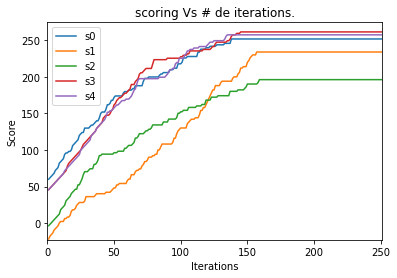

In [23]:
print_graf_scoring(res, best_score, bad_score)

### Prueba 2

In [24]:
res, best_score, bad_score, best_align = msa('hemog.fasta', score_mtx, -0.5,8,1500)

Solution 0 score: 174.35714285714238 order_added: [6, 4, 3, 0, 7, 5, 1, 2]
Solution 1 score: 175.57142857142816 order_added: [6, 5, 7, 3, 1, 0, 4, 2]
Solution 2 score: 205.49999999999957 order_added: [6, 4, 5, 7, 3, 1, 2, 0]
Solution 3 score: 205.49999999999963 order_added: [6, 4, 7, 3, 5, 1, 2, 0]
Solution 4 score: 104.99999999999991 order_added: [1, 0, 2, 3, 6, 5, 4, 7]
Solution 5 score: 205.49999999999963 order_added: [6, 4, 7, 3, 5, 1, 2, 0]
Solution 6 score: 310.00000000000045 order_added: [1, 0, 4, 5, 6, 7, 2, 3]
Solution 7 score: 289.64285714285757 order_added: [6, 5, 0, 3, 1, 4, 2, 7]


In [25]:
print('best_score:',best_score)

best_score: 2367.0


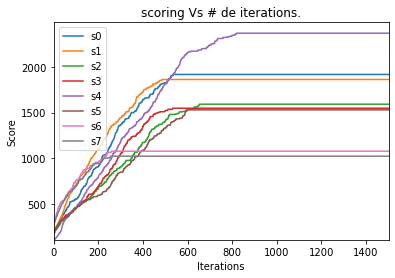

In [26]:
print_graf_scoring(res, best_score, bad_score)